<a href="https://colab.research.google.com/github/github-dorra/Brain_Tumor_Analytics/blob/main/brain_tumor_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [4]:
import pandas as pd
import numpy as np
import random
import os
from PIL import Image , ImageEnhance #pour pretraitement de l'image ou cv2

#keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential #(une seul input vs functional : plusieur input : dataset +csv)
from tensorflow.keras.layers import Input , Dense, Flatten , Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle #melange alea data pour modele apprend bienn que data ordonnee


**Flatten :** Les couches Dense n'acceptent que des vecteurs 1D en entrée. de passer des données 2D/3D a 1d

**Dense :**  chaque neurone est connecté à tous les neurones de la couche précédente

**Dropout :**  Désactive aléatoirement un pourcentage de neurones pendant l'entraînement

**Load dataset from github**

In [2]:
!git clone https://github.com/sartajbhuvaji/brain-tumor-classification-dataset
!ls
train_dir='brain-tumor-classification-dataset/Training'
test_dir='brain-tumor-classification-dataset/Testing'

#load and shuffel the train data
train_paths=[]
train_labels=[]
print(" * four dirc does exist in tranning dirc : ")
for label in os.listdir(train_dir):
  print(label)
  for image in os.listdir(os.path.join(train_dir,label)):
    train_paths.append(os.path.join(train_dir,label,image))
    train_labels.append(label)
train_paths,train_labels=shuffle(train_paths,train_labels)

#load and shuffel the test data
test_paths=[]
test_labels=[]
print(" * the same dirc does exist in testing dirc. ")
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    test_paths.append(os.path.join(test_dir,label,image))
    test_labels.append(label)
test_paths,test_labels=shuffle(test_paths,test_labels)

Cloning into 'brain-tumor-classification-dataset'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035 (from 1)
Receiving objects: 100% (3039/3039), 79.25 MiB | 14.12 MiB/s, done.
brain-tumor-classification-dataset  sample_data
 * four dirc does exist in tranning dirc : 
no_tumor
glioma_tumor
meningioma_tumor
pituitary_tumor
 * the same dirc does exist in testing dirc. 


**Data visualisation**

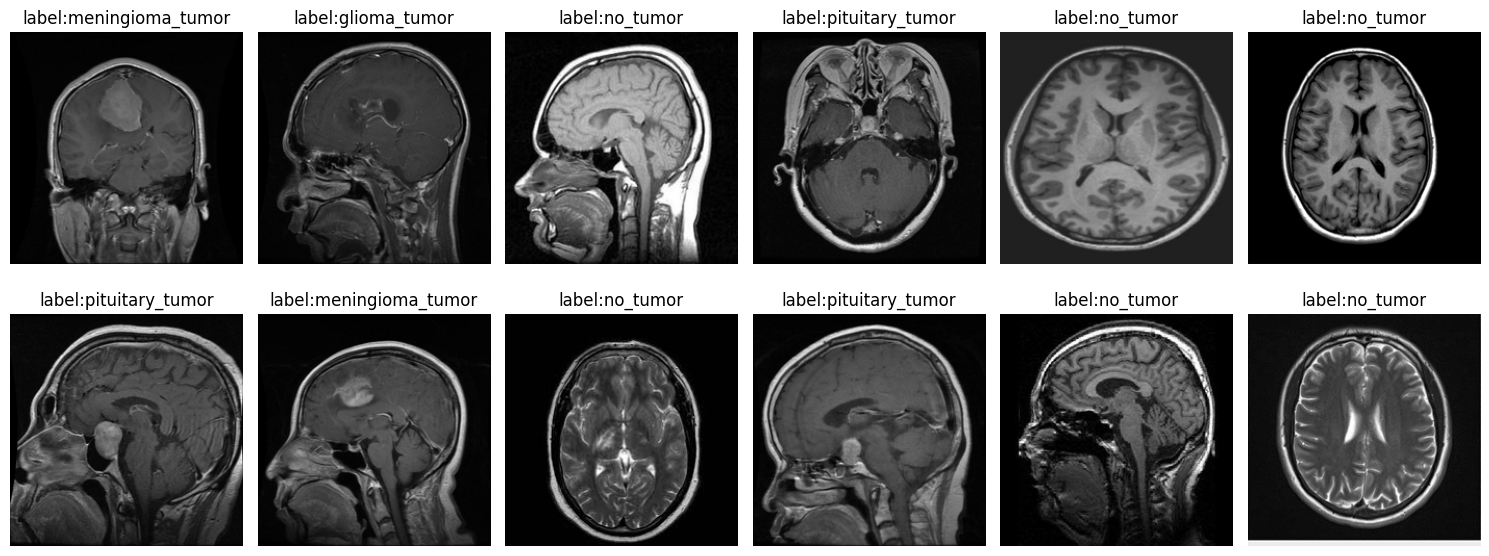

In [3]:
import matplotlib.pyplot as plt
#select random indices
random_indices= random.sample(range(len(train_paths)),12)

fig, axes = plt.subplots(2,6, figsize=(15,6))
axes = axes.ravel()

for i, ind in enumerate(random_indices):
  img = Image.open(train_paths[ind])
  img=img.resize((224,224))

  axes[i].imshow(img)
  axes[i].set_title(f"label:{train_labels[ind]}")
  axes[i].axis('off')

plt.tight_layout()
plt.show()

**Image Preprocessing**

image numpy = [
  
  [10 ,20,30,50,50,50,10]
  [30,..]


]

In [19]:
#image augmentation :image réelle → Augmentation → 10+ images variées
def augment_img(image):
  #image= Image.fromarray(np.uint8(image)) #conv image en objet pil
  image= ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2)) # mod aleatoir de luminosité
  image= ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2)) # mod aleatoir de contraste


  image = np.array(image)/255.0  # normalisation : image 0-1
  return image

def open_img(paths):
  #open image sous cette forme [20,50,50,10,20]
  images=[]
  for path in paths:
    img =load_img(path, target_size=(Image_size,Image_size))
    img =augment_img(img)
    images.append(img)
  return np.array(images)


#encoder label to integer
def encode_label(labels):
  label_encoded={
      'no_tumor':0,
      'glioma_tumor':1,
      'meningioma_tumor':2,
      'pituitary_tumor':3
  }
  # Convertir les labels texte en entiers
  encoded = [label_encoded[label] for label in labels]
  return np.array(encoded)


#data generator : charger les images par lots
def data_generator(paths,labels,batch_size= 20 , epochs=1):
  for _ in range(epochs):
    for i in range(0, len(paths),batch_size):
      batch_paths=paths[i:i+batch_size]
      batch_labels=labels[i:i+batch_size]
      batch_images=open_img(batch_paths)
      batch_labels=encode_label(batch_labels)
      yield batch_images,batch_labels





**Build Model**

**We try with VGG16**

VGG16 a deux parties :

Base (convolutionnelle) : extrait les features des images (filtres, patterns)

Top (classificateur) : couches Dense finales pour classifier en 1000 classes ImageNet

In [20]:
#model architecture RGB=(128,128,3):3: nombre of channel
Image_size=224
base_model=VGG16(input_shape=(Image_size,Image_size,3), include_top= False, weights='imagenet') #  false: on garde les couches convolutionnelles
                                                                                                #  weights: poids pre_entrainé ( poids : taux dimportance de chaque carateristique )
                                                                                                #  Imagenet: tres puissante : vgg16 est entrainer a detecter les bords, objets,formes

# Bloquer la mise à jour des poids pendant l'entrainement : snn rien tu as fais
"""On entraîne uniquement votre nouveau classificateur  : rapidité"""

for layer in base_model.layers:  #cette methode est appel fine tunnig ( tu peux specifier les layers a geler)
  layer.trainable=False

#set only the last few layers     For Knowledge
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True
base_model.layers[-5].trainable=True
base_model.layers[-6].trainable=True

**Choix de geler**

 * Couches BASSE (début)                
layers[0], [1], [2]...               
Apprennent : Bords, coins, couleurs   


* Couches MOYENNES                      
 layers[5], [6], [7]...                
 Apprennent : Textures, patterns       

  
* Couches HAUTE(fin)   
 layers[-4], [-3], [-2], [-1]          
  Apprennent : Parties d'objets:  SPÉCIFIQUES à ImageNet              
 Peuvent être adaptées à VOS données


In [24]:
#build model
model = Sequential()
model.add(base_model)
model.add(Flatten()) # 1D
model.add(Dropout(0.3))  #Desactiver 30% about layers in traning

model.add(Dense(128,activation='relu')) #128 neurones / relu: active valeur positive
model.add(Dropout(0.2))

model.add(Dense(4,activation='softmax')) # couche de sortie (output layer)
                                         #  4 neurones / softmax : activation de clasification multiclasse

"""Plus de couches Dense = Plus de paramètres à apprendre = Plus de risque d'overfitting"""
""" une seul couche Dense est suffisante pour adapter model a notre objectif"""


#compile model

model.compile(optimizer=Adam(learning_rate=0.00005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#parameters
batch_size=50  # 20 image par lot
epochs=20
steps=int(len(train_paths)/ batch_size)

#train model
history=model.fit(
    data_generator(train_paths,train_labels,batch_size=batch_size,epochs=epochs),
    steps_per_epoch=steps,
    epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 356ms/step - accuracy: 0.5472 - loss: 1.0392
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.8568 - loss: 0.3786
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.9235 - loss: 0.2165
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.9421 - loss: 0.1507
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.9554 - loss: 0.1244
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.9777 - loss: 0.0617
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.9898 - loss: 0.0322
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.9869 - loss: 0.0353
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.9936 - loss: 0.0252
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.9863 - loss: 0.0349
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.9950 - loss: 0.0161
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20

#**result graph**

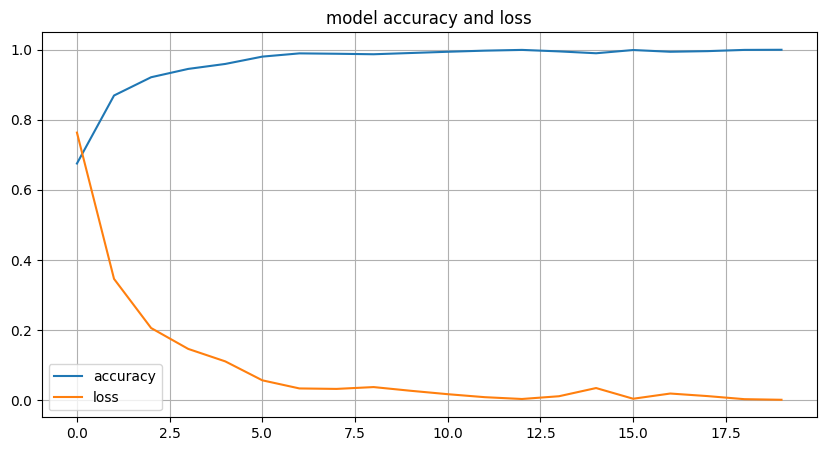

In [25]:
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['loss'],label='loss')
plt.title("model accuracy and loss")
plt.legend()
plt.show()

History :  Objet retourné par model.fit() Contient l'historique d'entraînement (loss, accuracy par epoch)

Utilisé pour visualiser la progression : history.history['loss']

#**Model classification Report**

In [26]:
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
from sklearn.preprocessing import label_binarize

test_images=open_img(test_paths)

prediction = model.predict(test_images)
test_labels=encode_label(test_labels)
print("classification report")
print(classification_report(test_labels,np.argmax(prediction,axis=1)))


13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 657ms/step
classification report
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       105
           1       1.00      0.23      0.37       100
           2       0.63      0.99      0.77       115
           3       1.00      0.82      0.90        74

    accuracy                           0.77       394
   macro avg       0.86      0.76      0.74       394
weighted avg       0.84      0.77      0.73       394



#**MRI tumor detection**

In [30]:
from keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt

class_label=[ 'no_tumor' ,'glioma_tumor','meningioma_tumor' ,'pituitary_tumor']
def detect_and_display(image_path,model):
  try:
      img = load_img(image_path,target_size=(Image_size,Image_size))
      img_array = img_to_array(img)
      img_normalized = img_array / 255.0  # Normalisation : mettre les valeurs entre 0 et 1
      img_for_prediction = np.expand_dims(img_normalized, axis=0)

      #prediction
      prediction = model.predict(img_for_prediction)      #0 = 0.90 , 1=0.60 , 2= 0.99 , 3= 0.55
      prediction_class_index =np.argmax(prediction)       #identifies the class with the highest predicted probability
      confience_score = np.max(prediction)                #Le format passe de (256, 256, 3) à (1}, 256, 256, 3)

      #deencoded label
      if class_label[prediction_class_index] == 'no_tumor':
        return "No Tumor is Detected"
      else:
        result= f"Tumor detected is:{class_label[prediction_class_index]}"

      #display
      plt.imshow(img)
      plt.title(f"{result} (confience: {confience_score * 100:.2f}%)")
      plt.axis('off')
      plt.show()

  except Exception as e:
    print(f"Error: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


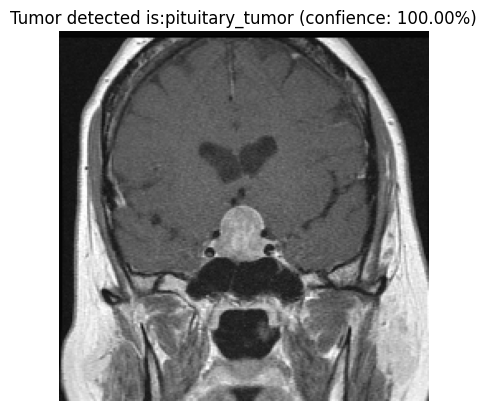

In [32]:
image_path='/content/brain-tumor-classification-dataset/Testing/pituitary_tumor/image(27).jpg'
detect_and_display(image_path,model)

#**coloration de tumeur**
**Segmentation de l'image + Coloration et Superposition**

In [34]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import cv2
# from tensorflow.keras.models import load_model # Nécessaire pour charger votre modèle

# --- 0. DÉFINITIONS GLOBALES (À ADAPTER) ---

# Taille des images (Doit correspondre à la taille d'entraînement)
Image_size = 224
class_label=['no_tumor' ,'glioma_tumor', 'meningioma_tumor' , 'pituitary_tumor']

# --- 1. FONCTION DE DÉTECTION ET D'OVERLAY ---

def detect_and_overlay(image_path, model):
    """
    Charge l'image, prédit la classe et crée l'image superposée avec un masque coloré.
    """
    try:
        # a) Chargement et préparation de l'image
        img_original_load = load_img(image_path, target_size=(Image_size, Image_size))
        img_array = img_to_array(img_original_load)

        # opencv verifie qq tt entier entre 0-255
        img_original_cv = img_array.astype(np.uint8)

        # Normalisation pour la prédiction
        img_normalized = img_array / 255.0
        img_for_prediction = np.expand_dims(img_normalized, axis=0)

        # b) Prédiction du Type de Tumeur
        prediction = model.predict(img_for_prediction)
        confidence = np.max(prediction)
        predicted_index = np.argmax(prediction)
        predicted_label = class_label[predicted_index]

        # --- c) SIMULATION DE SEGMENTATION ---

        # La logique réelle de segmentation (déterminer la position OÙ est la tumeur)

        # Création du Masque Binaire (0 ou 255)
        """ Principe du Masque Binaire ||Valeur 0 (Noir): Représente le fond ou le tissu sain | Valeur 255 (Blanc) : Représente la tumeur"""
        tumor_mask_binary = np.zeros((Image_size, Image_size), dtype=np.uint8)

        if predicted_label != 'no_tumor':
            # Si une tumeur est prédite, SIMULONS un masque pour l'affichage

            cv2.circle(tumor_mask_binary, (Image_size//2, Image_size//2), 30, 255, -1)

        # d) CRÉATION DE L'OVERLAY COLORÉ

        # Convertir l'original en couleur BGR (si c'est du niveau de gris)
        img_original_color = cv2.cvtColor(img_original_cv, cv2.COLOR_RGB2BGR)
        color_overlay = np.zeros_like(img_original_color, dtype=np.uint8)

        # Couleur : Rouge [B=0, G=0, R=255] pour la tumeur
        color_overlay[tumor_mask_binary == 255] = [0, 0, 255]

        # Mélange Alpha : 70% d'image originale, 30% de couleur
        alpha = 0.7
        beta = 0.3
        img_overlay = cv2.addWeighted(img_original_color, alpha, color_overlay, beta, 0)

        return img_original_load, img_overlay, predicted_label, confidence

    except Exception as e:
        print(f"Error in detect_and_overlay: {e}")
        return None, None, None, None # Retourne des valeurs par défaut en cas d'erreur

# --- 2. FONCTION D'AFFICHAGE DOUBLE ---

def display_side_by_side(img_original, img_overlay, predicted_label, confidence):

    # 1. Préparation du résultat textuel
    if predicted_label == 'no_tumor':
        result_text = "No Tumor is Detected"
        confidence_text=""

    else:
        result_text = f"Tumor detected is: {predicted_label}"
        confidence_text = f"Confiance: {confidence * 100:.2f}%"


    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # AFFICHAGE IMAGE ORIGINALE (Gauche)
    axes[0].imshow(img_original, cmap='gray')
    axes[0].set_title(f"1. Image Originale\n{result_text}", fontsize=14, color='blue')
    axes[0].axis('off')

    # AFFICHAGE IMAGE MODIFIÉE (Droite)
    # Conversion BGR (OpenCV) -> RGB (Matplotlib)
    if img_overlay.ndim == 3 and img_overlay.shape[2] == 3:
        img_display = cv2.cvtColor(img_overlay, cv2.COLOR_BGR2RGB)
    else:
        img_display = img_overlay

    axes[1].imshow(img_display)
    axes[1].set_title(f"2. Segmentation + Coloration\n{confidence_text}", fontsize=14, color='red')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


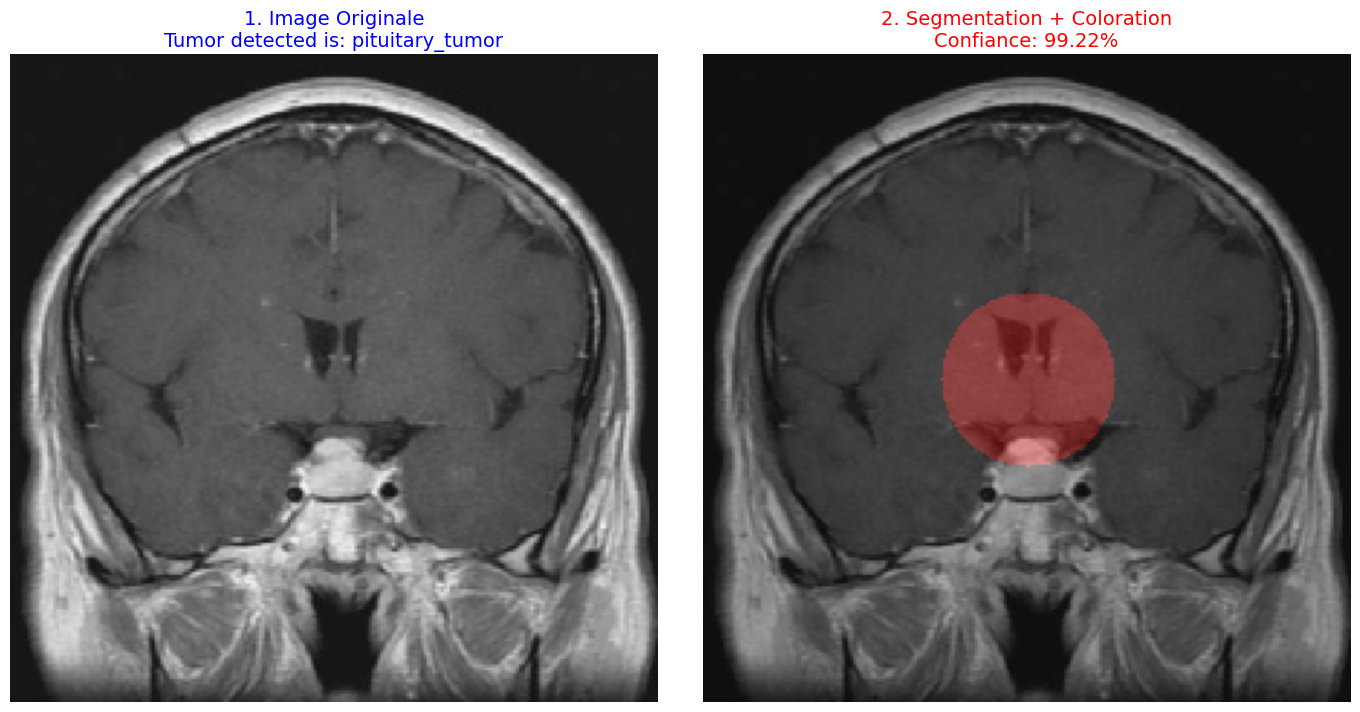

In [35]:
#  EXÉCUTION

image_path = '/content/brain-tumor-classification-dataset/Testing/pituitary_tumor/image(10).jpg'


# 1. Obtenir les deux images et les résultats
img_original, img_overlay, predicted_label, confidence = detect_and_overlay(image_path, model)

# 2. Afficher
if img_original is not None:
    display_side_by_side(img_original, img_overlay, predicted_label, confidence)

In [36]:
from google.colab import drive
drive.mount('/content/drive')
# ...
model.save('/content/drive/MyDrive/brain_tumor.keras')

Mounted at /content/drive


Modèle chargé avec succès.


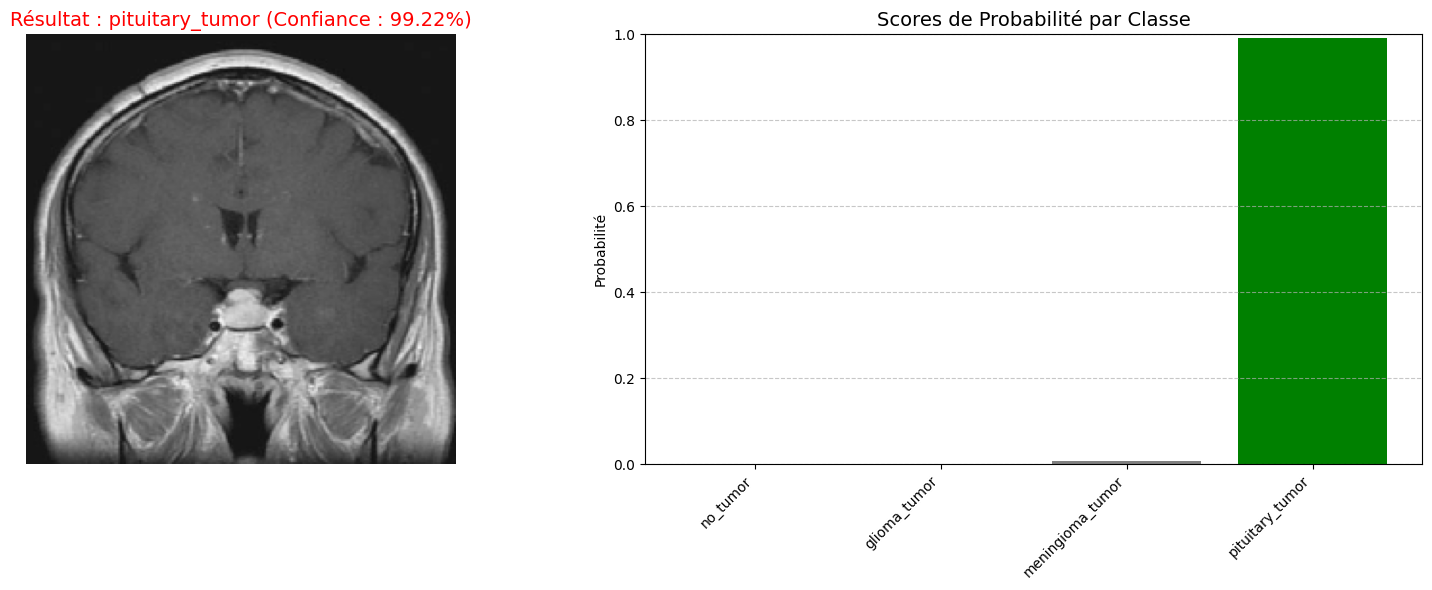

In [50]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/brain-tumor-classification-dataset/Testing/pituitary_tumor/image(10).jpg'

def detect_and_display_with_bar(image_path, brain_tumor):

    try:
        # 1. Chargement et préparation de l'image
        img_pil = load_img(image_path, target_size=(Image_size, Image_size))
        img_array = img_to_array(img_pil)
        img_normalized = img_array / 255.0
        img_for_prediction = np.expand_dims(img_normalized, axis=0)

        # 2. Prédiction
        prediction = brain_tumor.predict(img_for_prediction, verbose=0)

        prediction_scores = prediction[0]

        # 3. Interprétation des scores
        prediction_class_index = np.argmax(prediction_scores)
        confidence_score = np.max(prediction_scores)
        predicted_label_text = class_label[prediction_class_index]

        # 4. Préparation du titre et de la couleur pour l'affichage
        if predicted_label_text == 'no_tumor':
            main_title = "Résultat : AUCUNE TUMEUR DÉTECTÉE"
            title_color = 'blue'
        else:
            main_title = (f"Résultat : {predicted_label_text} "
                          f"(Confiance : {confidence_score * 100:.2f}%)")
            title_color = 'red'

        # --- 5. AFFICHAGE DE L'IMAGE ET DU GRAPHIQUE À BARRES ---
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Sous-graphique 1 : Affichage de l'Image
        axes[0].imshow(img_pil)
        axes[0].set_title(main_title, fontsize=14, color=title_color)
        axes[0].axis('off')

        # Sous-graphique 2 : Affichage du Graphique à Barres
        bar_positions = np.arange(len(class_label))

        # Définir les couleurs
        bar_colors = ['gray'] * len(class_label)
        bar_colors[prediction_class_index] = 'green'

        # Création du graphique
        axes[1].bar(bar_positions, prediction_scores, color=bar_colors)

        # Noms des labels
        axes[1].set_xticks(bar_positions)
        axes[1].set_xticklabels(class_label, rotation=45, ha='right', fontsize=10)

        # Mise en forme du graphique
        axes[1].set_title('Scores de Probabilité par Classe', fontsize=14)
        axes[1].set_ylabel('Probabilité')
        axes[1].set_ylim(0, 1)
        axes[1].grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        # Affiche l'erreur en cas de problème (ex: chemin d'image invalide)
        print(f"Erreur lors de la détection et de l'affichage : {e}")



image_path = '/content/brain-tumor-classification-dataset/Testing/pituitary_tumor/image(10).jpg'

# --- Chargement de votre Modèle ---

from tensorflow.keras.models import load_model
try:

    votre_modele_charge = load_model('/content/drive/MyDrive/brain_tumor.keras')
    print("Modèle chargé avec succès.")

    detect_and_display_with_bar(image_path, votre_modele_charge)

except Exception as e:
    print(f"\nERREUR: Impossible de charger le modèle. Assurez-vous que le chemin est correct. Détail: {e}")
